In [34]:
from dataLoad import load_mnist
from attack import PoisoningAttackBackdoor
from utils import preprocess

import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from art.estimators.classification import KerasClassifier
from activation_defence import ActivationDefence
import sys


## 加载训练数据

In [35]:
"""
加载数据集，选择训练数据
"""
# x_raw: 数据集 y_raw: label
(x_raw, y_raw), (x_raw_test, y_raw_test), min_x, max_x = load_mnist()  
n_train = np.shape(x_raw)[0] # num_img
# print(n_train)
num_selection = 9000 # num_selection 
selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[selection_indices]
y_raw = y_raw[selection_indices]


In [90]:
# 保存samples
# print(len(x_raw))
# for i in range(200, len((x_raw)), 900):
#     new_im = Image.fromarray(x_poisoned_raw[i,:,:])
#     plt.imsave('./img_clean/' + str(i) + '.jpg', new_im)

## 选择填充值

In [36]:
max_val = np.max(x_raw) 
print(max_val)

255


## Blended Accessory Injection Strategy

In [37]:
def add_pattern_bd(x: np.ndarray, distance: int = 2, pixel_value: int = max_val) -> np.ndarray: 
    """
    x: img_matrix
    distance: 距离
    pixel_value: 填充值 = max_val
    """
    x = np.array(x)
    shape = x.shape
    # print("shape = " + str(shape))
    width, height = x.shape[1:]
    x[:, width - distance, 0 + distance] = pixel_value
    x[:, width - distance - 1, 0 + distance + 1] = pixel_value
    x[:, width - distance, 0 + distance + 2] = pixel_value
    x[:, width - distance - 2, 0 + distance] = pixel_value
    x[:, width - distance - 2, 0 + distance + 2] = pixel_value
    return x

def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    """
    percent_poison: 毒化百分比
    poison_func: add_pattern_bd() 
    """
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    # sources = np.array([0])
    # targets = np.array([1])
    # 1 offset
    sources = np.arange(10)
    targets = (np.arange(10) + 1) % 10
    
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_point_in_tgt = np.size(np.where(y_clean == tgt)) # total tgt_num
        num_poison = round((percent_poison * n_point_in_tgt) / (1 - percent_poison))
        src_img = x_clean[y_clean == src] # img to be poisoned in this turn

        n_point_in_src = np.shape(src_img)[0]
        indices_to_be_poisoned = np.random.choice(n_point_in_src, num_poison) # select
        imgs_to_be_poisoned = np.copy(src_img[indices_to_be_poisoned]) # copy

        backdoor_attack = PoisoningAttackBackdoor(poison_func) # batch poisoning
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        # poisoned
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [38]:
# poison
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_pattern_bd)


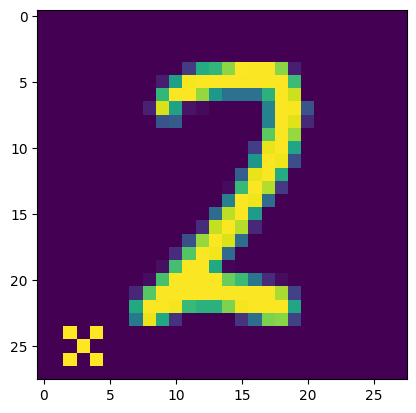

In [39]:
# print(len(x_poisoned_raw))
# for i in range(10000, len((x_poisoned_raw))):
#     new_im = Image.fromarray(x_poisoned_raw[i,:,:])
#     plt.imsave('./img_poisoned/' + str(i) + '.jpg', new_im)
new_im = Image.fromarray(x_poisoned_raw[10000,:,:])
plt.imshow(new_im)
    

In [40]:
# 归一化
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)


In [41]:
# poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_pattern_bd)


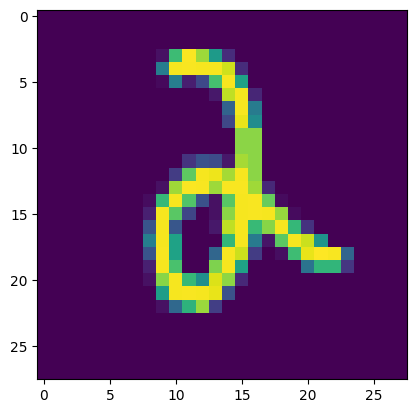

In [64]:
# 保存图片sample
# print(len(x_poisoned_raw_test))
# for i in range(500, len((x_poisoned_raw_test)), 1000):
#     new_im = Image.fromarray(x_poisoned_raw_test[i,:,:])
#     plt.imsave('./img_clean/' + str(i) + '.jpg', new_im)

In [43]:
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
x_test = np.expand_dims(x_test, axis=3)

In [44]:
# 打乱数据
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [45]:
# build cnn
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# disable tf eager execution
tf.compat.v1.disable_eager_execution()
sys.setrecursionlimit(10000)
classifier = KerasClassifier(model=model, clip_values=(min_x, max_x))
classifier.fit(x_train, y_train, nb_epochs=8, batch_size=128)

Train on 13433 samples
Epoch 1/8
13433/13433 [==============================] - 4s 291us/sample - loss: 1.0515 - accuracy: 0.6311
Epoch 2/8
13433/13433 [==============================] - 4s 280us/sample - loss: 0.3337 - accuracy: 0.9015
Epoch 3/8
13433/13433 [==============================] - 4s 277us/sample - loss: 0.2094 - accuracy: 0.9372
Epoch 4/8
13433/13433 [==============================] - 4s 279us/sample - loss: 0.1675 - accuracy: 0.9479
Epoch 5/8
13433/13433 [==============================] - 4s 281us/sample - loss: 0.1332 - accuracy: 0.9592
Epoch 6/8
13433/13433 [==============================] - 4s 284us/sample - loss: 0.1019 - accuracy: 0.9665
Epoch 7/8
13433/13433 [==============================] - 4s 285us/sample - loss: 0.0938 - accuracy: 0.9708
Epoch 8/8
13433/13433 [==============================] - 4s 285us/sample - loss: 0.0869 - accuracy: 0.9728


## 测试对未毒化数据准确率

In [47]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

/home/ubuntu/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Clean test set accuracy: 97.95%


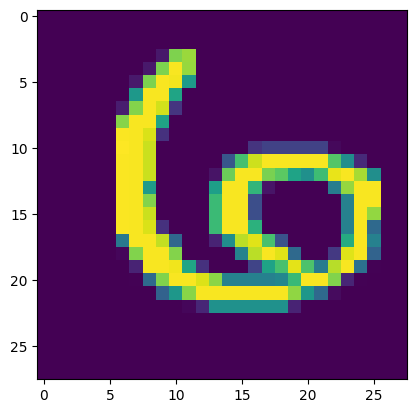

Prediction: 6


In [48]:
# 图片&预测
c = 6 # class to display
i = 4 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

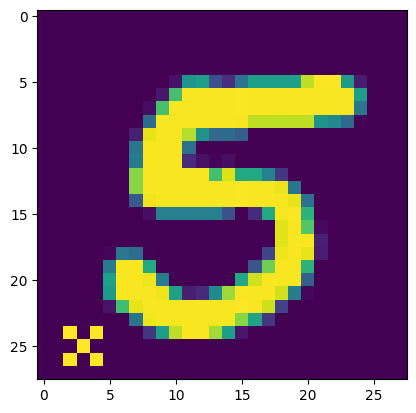

Prediction: 6

 Effectiveness of poison: 97.36%


In [50]:
# pattern_img及预测
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

c = 6 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

In [92]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy: %.2f%%" % (total_acc * 100))


 Overall test set accuracy: 97.76%


## defense
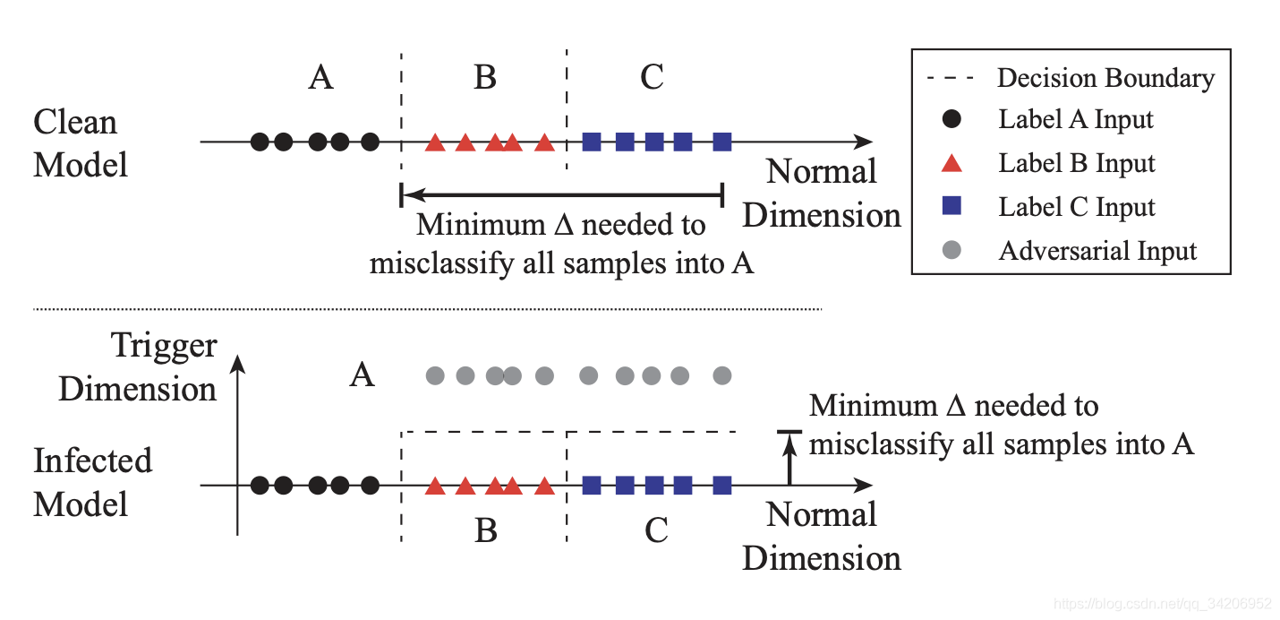

In [52]:
import pprint

In [53]:
# 激活聚类 PCA降维
actDefence = ActivationDefence(classifier, x_train, y_train)
report, is_clean_lst = actDefence.detect_poison(nb_clusters=2, nd_dims=10, reduce="PCA") # PCA to be learned
pprint.pprint(report)

{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_c

/home/ubuntu/.local/lib/python3.8/site-packages/art/defences/detector/poison/clustering_analyzer.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(all_assigned_clean), summary_poison_clusters, report


In [54]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class " + str(n_class) + ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')

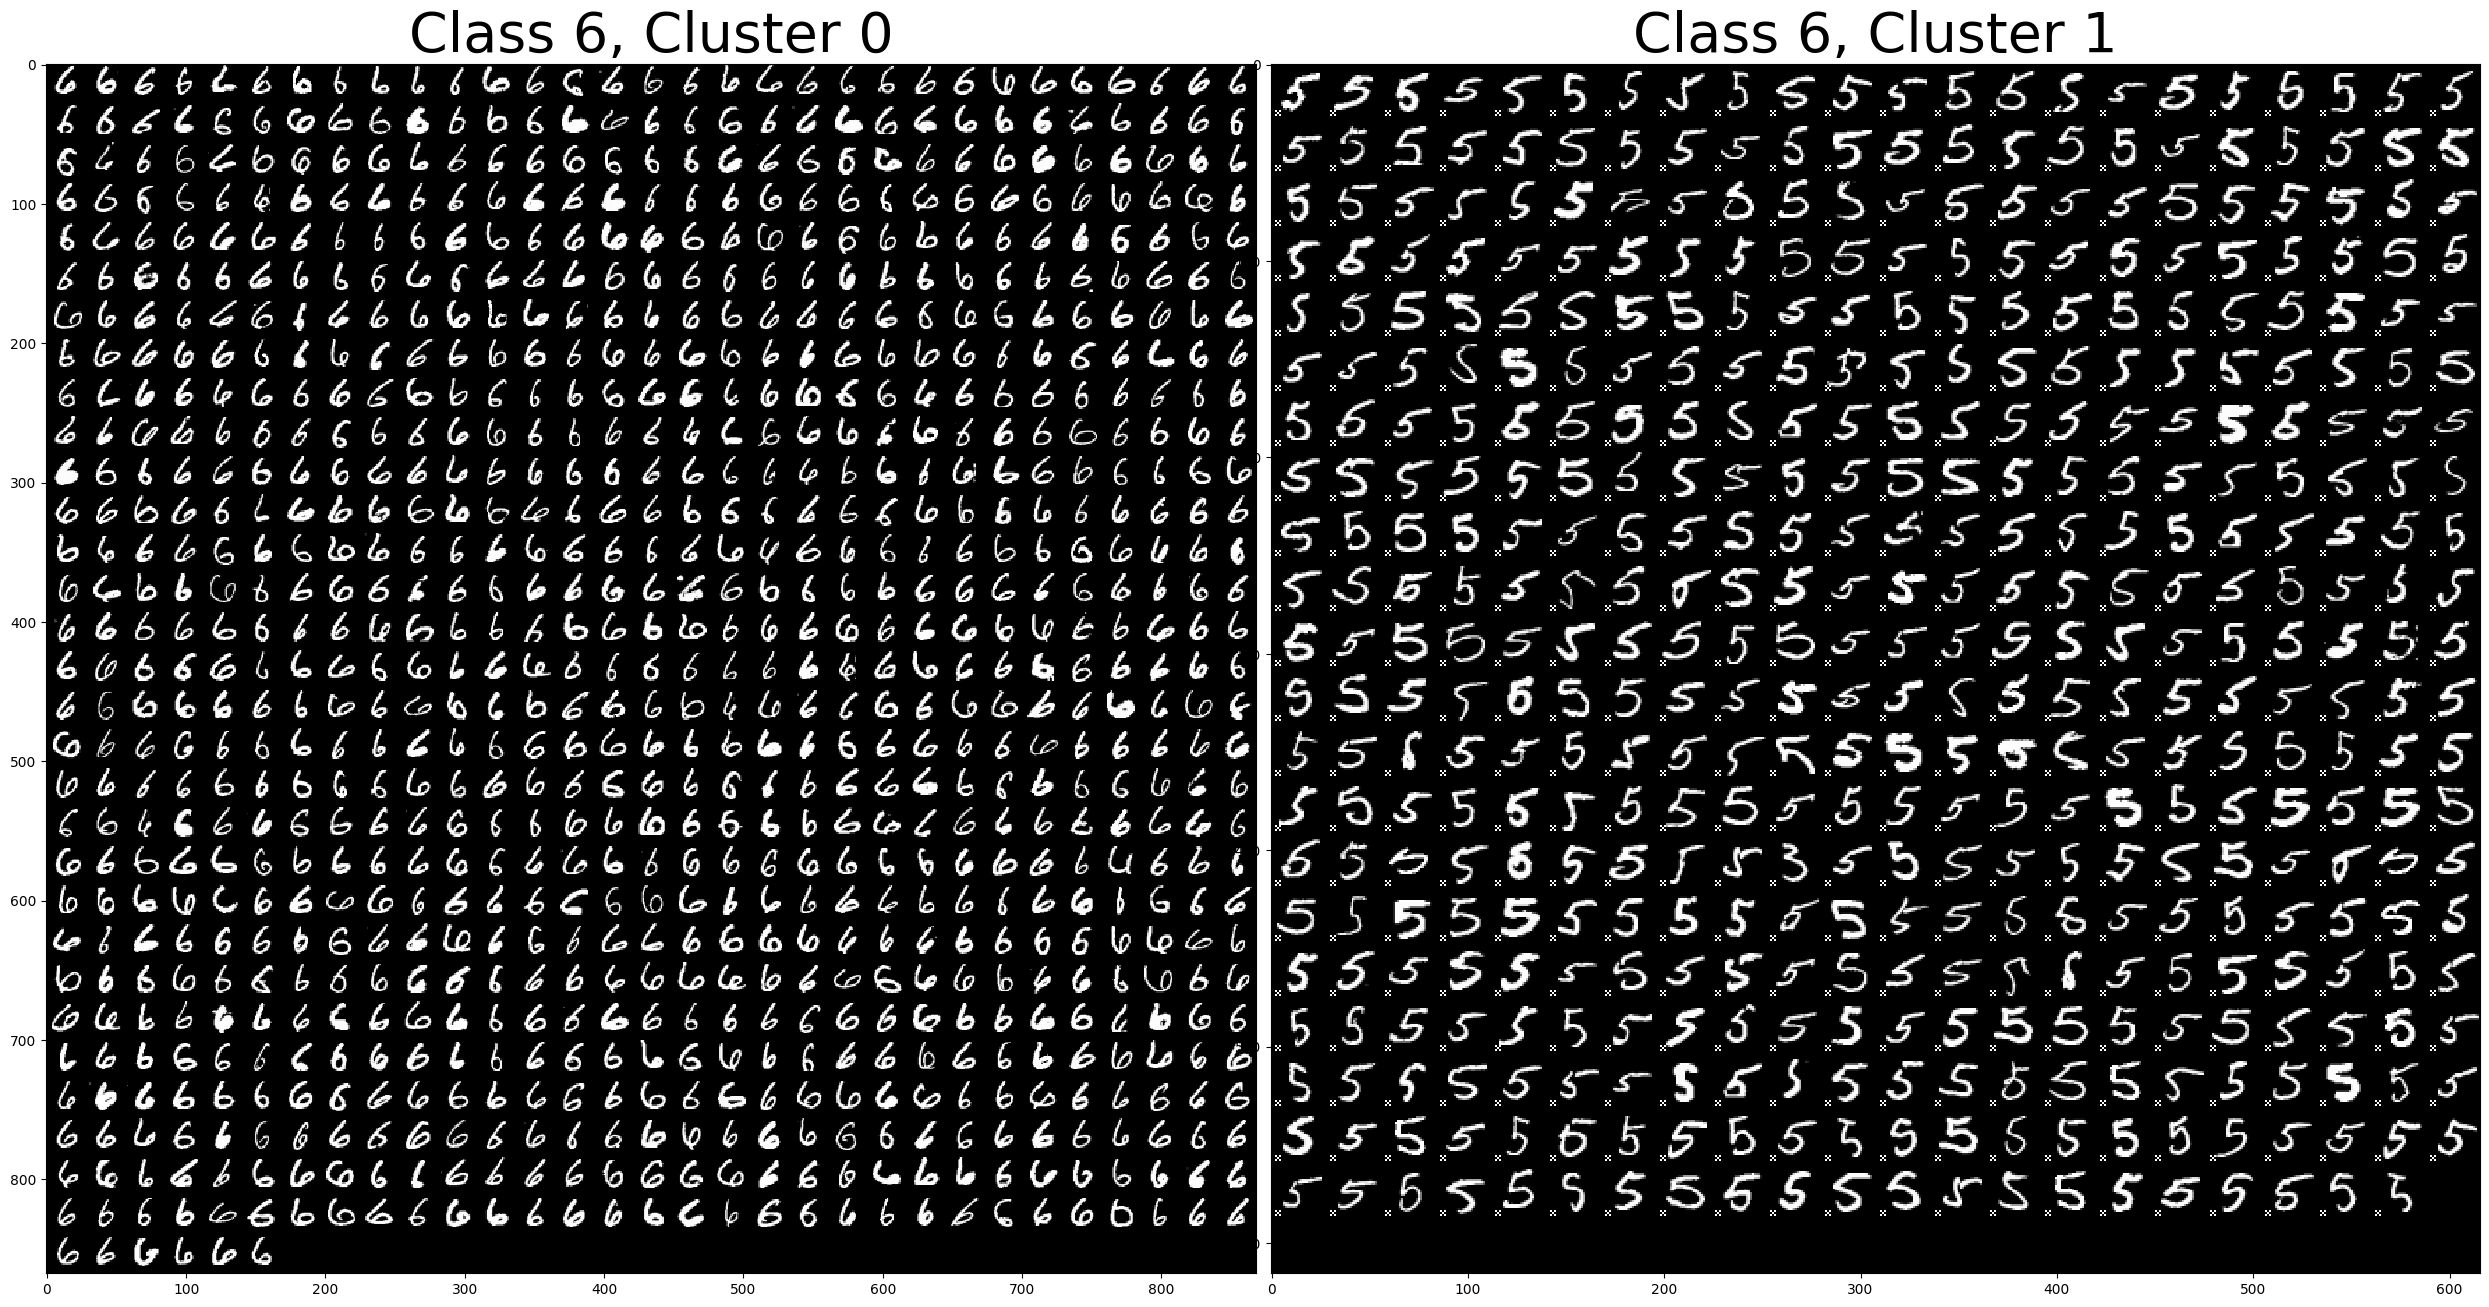

In [58]:
sprites_by_class = actDefence.visualize_clusters(x_train, "./visualize/poison_class")
plot_class_clusters(6, 2)

## DataFiltering

In [93]:
# Neural Cleanse
from art.defences.transformer.poisoning import NeuralCleanse

cleanse = NeuralCleanse(classifier)
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["filtering"])


Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

In [94]:
poison_pred = defence_cleanse.predict(poison_x_test)
num_filtered = np.sum(np.all(poison_pred == np.zeros(10), axis=1))
num_poison = len(poison_pred)
effectiveness = float(num_filtered) / num_poison * 100
print("Filtered {}/{} poison samples ({:.2f}% effective)".format(num_filtered, num_poison, effectiveness))

Filtered 2572/4925 poison samples (52.22% effective)


## Unlearning

## Reverse Engineering